Taking the datframes and putting .png in place of .tif

In [1]:
import os
import pandas as pd
import numpy as np
import cv2

In [ ]:
#Making the directory CSV_PNG
!mkdir '/content/drive/MyDrive/CovCT/CSV_PNG'

In [ ]:
#Making the directory images_PNG
!mkdir '/content/drive/MyDrive/CovCT/images_PNG'

In [ ]:
#Here the convertion takesplace
# Run this code for every modeule CSV File
df_test = pd.read_csv('/content/drive/MyDrive/CovCT/CSV/test5.csv')
df_train = pd.read_csv('/content/drive/MyDrive/CovCT/CSV/train5.csv')
df_val = pd.read_csv('/content/drive/MyDrive/CovCT/CSV/validation5.csv')

test = df_test.replace({'.tif': '.png'}, regex=True)
train = df_train.replace({'.tif': '.png'}, regex=True)
val = df_val.replace({'.tif':'.png'}, regex=True)

#Saving to another directory named CSV_PNG
test.to_csv('/content/drive/MyDrive/CovCT/CSV_PNG/test5.csv')
train.to_csv('/content/drive/MyDrive/CovCT/CSV_PNG/train5.csv')
val.to_csv('/content/drive/MyDrive/CovCT/CSV_PNG/val5.csv')

In [ ]:
#CSV column to list 
data = pd.read_csv('/content/drive/MyDrive/CovCT/CSV/train5.csv')
images = data.filename.tolist()

In [ ]:
#Now convert the images to the PNG format from the raster Tiff form
directory = '/content/drive/MyDrive/CovCT/images'
new_directory = '/content/drive/MyDrive/CovCT/images_PNG'
#counter for process image 
count = 0
for filename in images:
  new_filename = filename.replace(".tif",".png")
  #Check if image already exists (In case of failures in between)
  if(os.path.exists(os.path.join(new_directory,new_filename))):
    count+=1
    if(count%50==0):
      print(count)
  else:
    image = cv2.imread(os.path.join(directory, filename),-1)
    img_scaled = cv2.normalize(image, dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
    cv2.imwrite(os.path.join(new_directory,new_filename),img_scaled/255)
    count+=1
    if(count%50==0):
      print(count)

The model training part starts from **here**. 


*   The preparation of the data pipelines
*   Feeding data pipelines to the efficientNet



In [2]:
#all the imports go here
import keras
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input, GlobalAveragePooling2D
from keras.applications.efficientnet import EfficientNetB0 as Net
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import RandomNormal
import keras.backend as k
from sklearn.utils import shuffle
from sklearn.utils import shuffle
import csv
import matplotlib.pyplot as plt

Preparing the data Generators.

In [3]:
#Here we set the data generators for applying data augmentation methods
train_datagen = ImageDataGenerator(horizontal_flip=True,zoom_range=0.05,rotation_range=360,width_shift_range=0.05,height_shift_range=0.05,shear_range=0.05)
test_datagen = ImageDataGenerator()
train_df1 =pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/train{}.csv'.format(1)) #raed train csv file
train_df2 =pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/train{}.csv'.format(2)) #raed train csv file
train_df3 =pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/train{}.csv'.format(3)) #raed train csv file
train_df4 =pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/train{}.csv'.format(4)) #raed train csv file
train_df5 =pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/train{}.csv'.format(5)) #raed train csv file

train_df = pd.concat([train_df1,train_df2,train_df3, train_df4, train_df5])
train_df = shuffle(train_df) #Shuffle the train data


validation_df1 = pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/val{}.csv'.format(1)) #raed validation csv file (Validation in the training process)
validation_df2 = pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/val{}.csv'.format(2))
validation_df3 = pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/val{}.csv'.format(3))
validation_df4 = pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/val{}.csv'.format(4))
validation_df5 = pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/val{}.csv'.format(5))

validation_df = pd.concat([validation_df1,validation_df2,validation_df3, validation_df4,validation_df5])


test_df1 = pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/test{}.csv'.format(1))
#raed test csv file (For evaluating the final version of the trained network)
test_df2 = pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/test{}.csv'.format(2))
test_df3 = pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/test{}.csv'.format(3))
test_df4 = pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/test{}.csv'.format(4))
test_df5 = pd.read_csv('/content/drive/MyDrive/CovCT/CSV_PNG/test{}.csv'.format(5))


test_df = pd.concat([test_df1,test_df2,test_df3, test_df4, test_df5])

In [4]:
shape=(512,512,1) #shape of the dataset images (in PNG format)

In [5]:
#Create the generators
train_generator = train_datagen.flow_from_dataframe(
      dataframe=train_df,
      directory='/content/drive/MyDrive/CovCT/images_PNG',
      x_col="filename",
      y_col="class",
      target_size=shape[:2],
      batch_size=10,
      class_mode='categorical',color_mode="grayscale",shuffle=True)
validation_generator = test_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='/content/drive/MyDrive/CovCT/images_PNG',
        x_col="filename",
        y_col="class",
        target_size=shape[:2],
        batch_size=10,
        class_mode='categorical',color_mode="grayscale",shuffle=True)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='/content/drive/MyDrive/CovCT/images_PNG',
        x_col="filename",
        y_col="class",
        target_size=shape[:2],
        batch_size=20,
        class_mode='categorical',color_mode="grayscale",shuffle=True)

Found 18746 validated image filenames belonging to 2 classes.
Found 4532 validated image filenames belonging to 2 classes.
Found 41544 validated image filenames belonging to 2 classes.


Deciding the architecture

In [ ]:
#New type raining of model
#Training the model 
# The model produces separate layers and also doesn't include the efficient net as a one Layer
input_tensor=Input(shape=shape)

#Load EfficientNetB1 ImageNet pre-trained weights
weight_model = Net(weights='imagenet', include_top=False) 
#Save the weights
weight_model.save_weights('weights_eff.h5') 
#Load the EfficientnetB1 model without weights
base_model = Net(weights=None, include_top=False, input_tensor=input_tensor) 
#Load the ImageNet weights on the ResNet50V2 model except the first layer(because the first layer has one channel in our case)
base_model.load_weights('weights_eff.h5',skip_mismatch=True, by_name=True) 
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax')(x)
model = Model(inputs=input_tensor , outputs=x)

In [ ]:
#Training the model 
#input_tensor=Input(shape=shape)

#Load EfficientNetB1 ImageNet pre-trained weights
#weight_model = Net(weights='imagenet', include_top=False) 
#Save the weights
#weight_model.save_weights('weights_eff.h5') 
#Load the EfficientnetB1 model without weights
#base_model = Net(weights=None, include_top=False, input_tensor=input_tensor) 
#Load the ImageNet weights on the ResNet50V2 model except the first layer(because the first layer has one channel in our case)
#base_model.load_weights('weights_eff.h5',skip_mismatch=True, by_name=True) 

#model = Sequential()
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dropout(0.3))
#model.add(Dense(2, activation='softmax'))
#model.summary()

for layer in model.layers:
  layer.trainable = True
#DECIDING THE CALLBACKS
optimizer=optimizers.Nadam(learning_rate=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 3, factor= 0.2, min_lr= 1e-6, verbose=1)#model compiling

ModelCheck = ModelCheckpoint('/content/drive/MyDrive/CovCT/models5/model_five_fold-{epoch:02d}-{val_accuracy:.4f}.hdf5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
#Start the training
callbacks_list = [early_stop, rlrop, ModelCheck]
model.fit_generator(train_generator, epochs=20,validation_data=validation_generator,shuffle=True,callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1875/1875 [==============================] - 3232s 2s/step - loss: 0.2705 - accuracy: 0.8769 - val_loss: 0.0926 - val_accuracy: 0.9634

Epoch 00001: val_accuracy improved from -inf to 0.96337, saving model to /content/drive/MyDrive/CovCT/models5/model_five_fold-01-0.9634.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
1875/1875 [==============================] - 1012s 540ms/step - loss: 0.0548 - accuracy: 0.9838 - val_loss: 0.0318 - val_accuracy: 0.9896

Epoch 00002: val_accuracy improved from 0.96337 to 0.98963, saving model to /content/drive/MyDrive/CovCT/models5/model_five_fold-02-0.9896.hdf5
Epoch 3/20
1875/1875 [==============================] - 1012s 540ms/step - loss: 0.0382 - accuracy: 0.9885 - val_loss: 0.0931 - val_accuracy: 0.9607

Epoch 00003: val_accuracy did not improve from 0.98963
Epoch 4/20
1875/1875 [==============================] - 1014s 540ms/step - loss: 0.0335 - accuracy: 0.9888 - val_loss: 0.0280 - val_accuracy: 0.9892

Epoch 00004: val_accuracy did not improve from 0.98963
Epoch 5/20
1875/1875 [==============================] - 1014s 540ms/step - loss: 0.0255 - accuracy: 0.9902 - val_loss: 0.0147 - val_accuracy: 0.9958

Epoch 00005: val_accuracy improved from 0.98963 to 0.99581, saving model to /content/drive/MyDrive/CovCT/models5/model_five_fold-05-0.9958.hdf5
Ep

In [ ]:
#Model Evaluation
state = 1
trained_models=[]
for r,d,f in os.walk('/content/drive/MyDrive/CovCT/models5/'): #Take the path to the trained nets 
  for file in f:
    if '.hdf5' in file:
      trained_models.append(os.path.join(r,file))
print(len(trained_models))
reports=[]
for trn_model in trained_models: #evaluate the network on each trained net
  k.clear_session()
  netpath=trn_model 
  model_name=trn_model
  print(trn_model)
  #fold_num=trn_model[trn_model.index('fold')+4] #find the fold number
  net=keras.models.load_model(netpath) #load model
  covid_label= test_generator.class_indices['covid'] #get the index of COVID-19 class 
  normal_label= test_generator.class_indices['normal']  #get the index of normal class 
  tp=0 #True Positives
  fp=0 #False Positives
  anum=0 #All the images numbers
  ###########
  ctp=0 #Correct classified COVID-19 cases
  cfp=0 #Wrong classified COVID-19 cases
  cfn=0 #Not classified COVID-19 cases
  ctn=0 #Correctly not classified COVID-19 cases
  cnum=0 #Number of COVID cases
  ################
  ntp=0 #Correct classified normal cases
  nfp=0 #Wrong classified normal cases
  nfn=0 #Not classified normal cases
  ntn=0 #Correctly not classified normal cases
  nnum=0 #Number of normal cases
  for num,img_name in enumerate(test_generator.filenames): #load image
    gt_ind=test_generator.classes[num] #get the loaded image class index
    img=cv2.imread(os.path.join('/content/drive/MyDrive/CovCT/images_PNG',img_name),cv2.IMREAD_GRAYSCALE) #load image
    data = np.reshape(img,(1,512,512,1))
    pred_ind=np.argmax(net.predict(data)[0]) #get the predicted class index
    anum+=1 #count the number of images
    if(anum==1000):
      break
    if(anum%50==0):
      print(anum)
    if gt_ind==covid_label:
      cnum+=1
      if pred_ind==covid_label:
        tp+=1
        ctp+=1
        ntn+=1
      else:
        fp+=1
        nfp+=1
        cfn+=1
    elif gt_ind==normal_label:
      nnum+=1
      if pred_ind==normal_label:
        ctn+=1
        ntp+=1
        tp+=1
      else:
        cfp+=1
        nfn+=1
        fp+=1

  overall_acc=tp/(tp+fp) #overall accuracy
  cacc=(ctp+ctn)/(ctp+ctn+cfp+cfn) #covid accurayc
  nacc=(ntp+ntn)/(ntp+ntn+nfp+nfn) #normal accuracy
  csens=ctp/(ctp+cfn) #covid sensitivity
  nsens=ntp/(ntp+nfn) #normal sensitivity
  cspec=ctn/(ctn+cfp) #covid specificity
  nspec=ntn/(ntn+nfp) #normal specificity
  cprec=ctp/(ctp+cfp) #covid precision
  nprec=ntp/(ntp+nfp) #normal precision
  reports.append([model_name,tp,fp,ctp,cfn,cfp,ntp,nfn,nfp,overall_acc,cacc,nacc,csens,nsens,cspec,nspec,cprec,nprec])
  print(model_name)
  print('tp: ',tp,'fp: ',fp)

with open('FPN.csv', mode='w',newline='') as csv_file:
  csvwriter = csv.writer(csv_file, delimiter=',', quotechar='"',quoting=csv.QUOTE_MINIMAL)
  csvwriter.writerow(['model_name','tp','fp','ctp','cfn','cfp','ntp','nfn','nfp','overall_acc','cacc','nacc','csens','nsens','cspec','nspec','cprec','nprec'])
  for row in reports:
    csvwriter.writerow(row)

In [31]:
#A code block for testing the particular images on teh trained models

tp=0
for num,img_name in enumerate(test_generator.filenames): #load image
    gt_ind=test_generator.classes[num] #get the loaded image class index
    img=cv2.imread(os.path.join('/content/drive/MyDrive/CovCT/images_PNG',img_name),cv2.IMREAD_GRAYSCALE) #load image
    data = np.reshape(img,(1,512,512,1))
    pred_ind=np.argmax(net.predict(data)[0]) #get the predicted class index
    anum+=1 #count the number of images
    if(anum==1000):
      break
    if(anum%50==0):
      print(anum)
    if gt_ind==covid_label:
      cnum+=1
      if pred_ind==covid_label:
        if(tp==20):
          break
        tp+=1
        ctp+=1
        ntn+=1
      else:
        fp+=1
        nfp+=1
        cfn+=1
    elif gt_ind==normal_label:
      nnum+=1
      if pred_ind==normal_label:
        ctn+=1
        ntp+=1
        tp+=1
      else:
        cfp+=1
        nfn+=1
        fp+=1

50


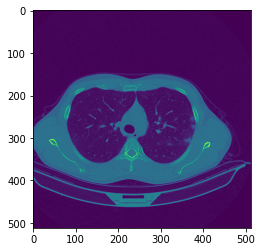

In [32]:
plt.imshow(data[0,:,:,0])

Compress the model using Tflite

In [19]:
import tensorflow as tf
#model = keras.models.load_model('/content/drive/MyDrive/CovCT/models5')
converter = tf.lite.TFLiteConverter.from_keras_model(net)
tflite_model = converter.convert()
open("/content/drive/MyDrive/CovCT/models5/converted_model99.tflite", "wb").write(tflite_model)
print("Executed")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpjvgs6tou/assets
Executed


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/CovCT/models/model_four_fold-04-09882.hdf5')

In [ ]:
#Saving teh weights of the model to load for the layer showing efficient net
net.save_weights('/content/drive/MyDrive/CovCT/models/allLayers.h5')

In [ ]:
input = Input(shape)
weightmodel = Net(weights=None, include_top=False, input_tensor=input)
weightmodel.load_weights('/content/drive/MyDrive/CovCT/models/allLayers.h5',by_name=True, skip_mismatch=True)


Now here, We have to create saliency maps using trained models


In [12]:
#Function returning 2D Numpy array (Values 0-1 (Normalized))
def ScoreCam(model, model1,img_array, max_N=-1):

    cls = np.argmax(model.predict(img_array)[0])
    act_map_array = Model(inputs=model.input, outputs=model.get_layer('block7a_project_conv').output).predict(img_array)
    print(act_map_array.shape)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    print(input_shape)

    # 1. upsample to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    print("step 1 done")
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    print("step 2 done")
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        masked_input = masked_input.astype('float32') 
        masked_input[0,:,:,0] *= act_map_normalized
        masked_input_list.append(masked_input)
    print("step 3 done")
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    print("step 4 done")
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    print("step 5 done")
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    print("step 6 done")
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

In [33]:
cam = ScoreCam(net,None, data)

(1, 16, 16, 320)
(512, 512, 1)
step 1 done
step 2 done
step 3 done
step 4 done
step 5 done
step 6 done


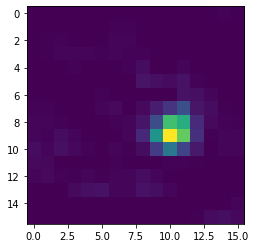

In [34]:
plt.imshow(cam)


In [35]:
cv2.imwrite('test.jpg',img)

True

In [15]:
mask = np.zeros_like(cam, dtype='float32')
for i in range(16):
  for j in range(16):
    if(cam[i,j]>0.7):
      mask[i,j] = cam[i,j]

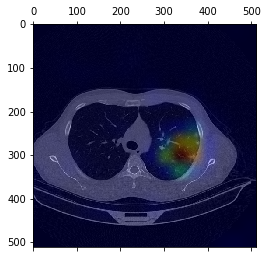

In [36]:
import matplotlib.cm as cm
img11 = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
save_and_display_gradcam(img11,cam)

In [23]:
def save_and_display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    cv2.imwrite('heat.jpg',jet_heatmap)
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    super_im = keras.preprocessing.image.img_to_array(superimposed_img)
    cv2.imwrite('heat_imposed.jpg',super_im)

    # Save the superimposed image

    # Display Grad CAM
    plt.matshow(superimposed_img)
    plt.show()